# 텐서플로우를 이용한 GANs (Generative Adversarial Networks) 예제

GANs는 오토인코더와 마찬가지로 대표적인 unsupervised model의 하나입니다. 
* 위폐범은 위조화폐를 정교하게 만들고자 최선을 다합니다. 즉 경찰이 실수할 확률을 높이기 위해 노력합니다.
* 경찰은 위폐를 감별하기 위해 최선을 다합니다. 즉 자신이 실수할 확률을 낮추기 위해 노력합니다. 
* 위폐범(G)의 네트워크를 Generative Network라고 합니다. 
* 경찰(D)의 네트워크를 Discriminator Network라고 합니다. 
* G는 D의 실수할 확률을 높이기 위해 노력하고 (maximize), D는 자신의 실수 확률을 낮추기 위해 노력하므로 (minimize) 이는 minimax problem입니다.
* GANs에서는 어려운 확률분포를 다루는 대신에 확률로부터 생성된 샘플을 다룹니다.
* G는 Z를 입력으로 받기 때문에 G(Z)로 표현하는데, 이때 Z가 바로 확률분포와 맵핑되는 prior라는 개념입니다. Random noise가 됩니다.
* 이때 G(Z)의 결과물은 물론 위폐가 됩니다.
* D는 이미지 X를 입력으로 받기 때문에 D(X)로 표현하며, D(X)의 결과물은 확률 (0~1) 이 됩니다.
* 양자의 균형을 맞추는 평형 상태에 이르면 G는 진짜 화폐와 100% 동일한 화폐를 만들게 되며, D가 이를 감별할 확률은 0.5가 되게 됩니다.

### 1. 필요한 모듈들을 불러 옵니다.

In [113]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tensorflow.examples.tutorials.mnist import input_data

In [114]:
mnist = input_data.read_data_sets('data/mnist', one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


가중치의 초기화에 좋은 성능을 보이는 xavier initialization을 함수로 만들어서 이용합니다.

In [115]:
def xavier_init(shape):
    dim1 = shape[0]
    stddev = 1. / tf.sqrt(dim1 / 2.)
    return tf.random_normal(shape=shape, stddev=stddev)

Discriminator 네트워크를 구축합니다.
* D(X) 를 통해 확률을 출력하게 됩니다.
* 노드수 : 784 --> 128 --> 1

In [116]:
# Discriminator Net

X = tf.placeholder(tf.float32, shape=[None, 784], name='X')

W1_dis = tf.Variable(xavier_init([784, 128]), name='W1_dis')
b1_dis = tf.Variable(tf.zeros(shape=[128]), name='b1_dis')

W2_dis = tf.Variable(xavier_init([128, 1]), name='W2_dis')
b2_dis = tf.Variable(tf.zeros(shape=[1]), name='b2_dis')

theta_dis = [W1_dis, W2_dis, b1_dis, b2_dis]

Generator 네트워크를 구축합니다. 
* G(Z)를 통해 이미지를 출력하게 됩니다.
* 노드 수 : 100 --> 128 --> 784

In [117]:
# Generator Net
Z = tf.placeholder(tf.float32, shape=[None, 100], name='Z')

W1_gen = tf.Variable(xavier_init([100, 128]), name='W1_gen')
b1_gen = tf.Variable(tf.zeros(shape=[128]), name='b1_gen')

W2_gen = tf.Variable(xavier_init([128, 784]), name='W2_gen')
b2_gen = tf.Variable(tf.zeros(shape=[784]), name='b2_gen')

theta_gen = [W1_gen, W2_gen, b1_gen, b2_gen]

In [118]:
def random_Z(z1, z2):
    return np.random.uniform(-1, 1, size=[z1, z2])

In [119]:
def gen(z):
    h1_gen = tf.nn.relu(tf.matmul(z, W1_gen) + b1_gen)
    log_prob_gen = tf.matmul(h1_gen, W2_gen) + b2_gen
    prob_gen = tf.nn.sigmoid(log_prob_gen)

    return prob_gen

In [120]:
def dis(x):
    h1_dis = tf.nn.relu(tf.matmul(x, W1_dis) + b1_dis)
    logit_dis = tf.matmul(h1_dis, W2_dis) + b2_dis
    prob_dis = tf.nn.sigmoid(logit_dis)

    return prob_dis, logit_dis

In [130]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    grid = gridspec.GridSpec(4, 4)
    grid.update(wspace=0.1, hspace=0.1)

    for i, sample in enumerate(samples):
        ax = plt.subplot(grid[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='gray')

    return fig

GAN을 학습시키기 위한 Adversarial Process를 선언합니다.

In [122]:
sample_gen = gen(Z)
real_dis, logit_real_dis = dis(X)
fake_dis, logit_fake_dis = dis(sample_gen)

In [123]:
loss_real_dis = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_real_dis, labels=tf.ones_like(logit_real_dis)))
loss_fake_dis = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_fake_dis, labels=tf.zeros_like(logit_fake_dis)))
loss_dis = loss_real_dis + loss_fake_dis
loss_gen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit_fake_dis, labels=tf.ones_like(logit_fake_dis)))

In [124]:
solver_dis = tf.train.AdamOptimizer().minimize(loss_dis, var_list=theta_dis)
solver_gen = tf.train.AdamOptimizer().minimize(loss_gen, var_list=theta_gen)

In [125]:
batch_size = 128
dim_Z = 100

In [126]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

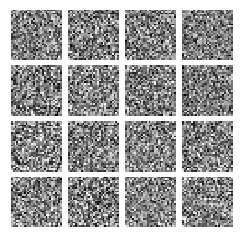

Iteration: 0
Discriminator loss: 1.03
Generator loss: 2.82



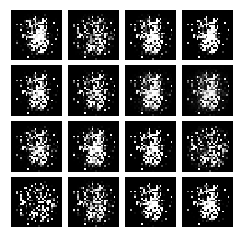

Iteration: 2000
Discriminator loss: 0.00591
Generator loss: 8.54



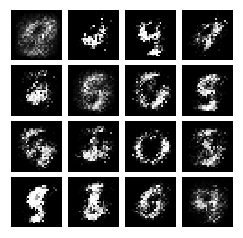

Iteration: 4000
Discriminator loss: 0.0843
Generator loss: 5.58



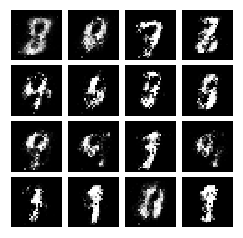

Iteration: 6000
Discriminator loss: 0.25
Generator loss: 5.47



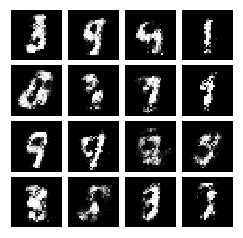

Iteration: 8000
Discriminator loss: 0.334
Generator loss: 4.11



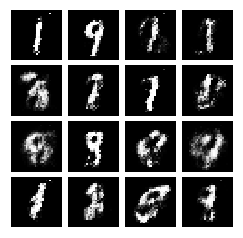

Iteration: 10000
Discriminator loss: 0.437
Generator loss: 3.2



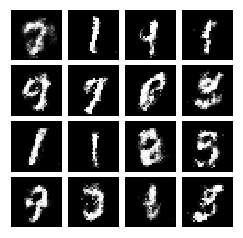

Iteration: 12000
Discriminator loss: 0.489
Generator loss: 2.72



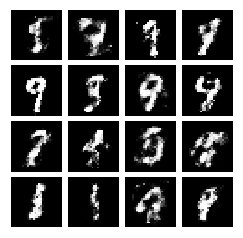

Iteration: 14000
Discriminator loss: 0.795
Generator loss: 2.48



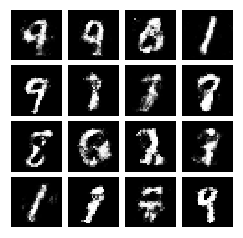

Iteration: 16000
Discriminator loss: 0.735
Generator loss: 2.5



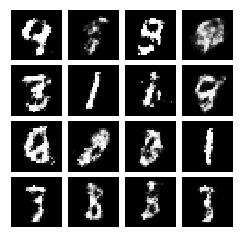

Iteration: 18000
Discriminator loss: 0.682
Generator loss: 2.2



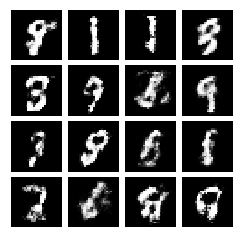

Iteration: 20000
Discriminator loss: 1.04
Generator loss: 2.01



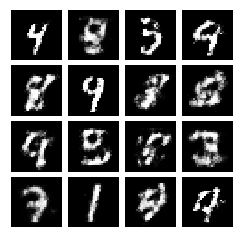

Iteration: 22000
Discriminator loss: 0.724
Generator loss: 2.38



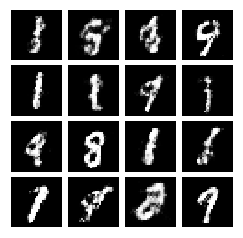

Iteration: 24000
Discriminator loss: 0.605
Generator loss: 2.57



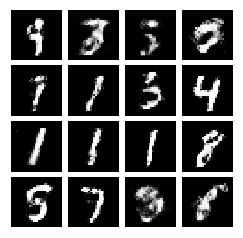

Iteration: 26000
Discriminator loss: 0.65
Generator loss: 2.26



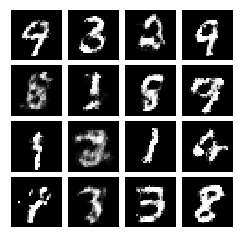

Iteration: 28000
Discriminator loss: 0.802
Generator loss: 2.51



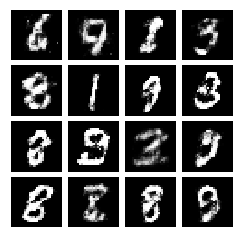

Iteration: 30000
Discriminator loss: 0.634
Generator loss: 2.38



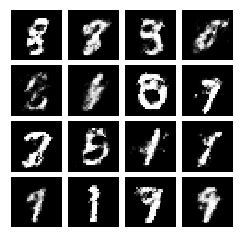

Iteration: 32000
Discriminator loss: 0.599
Generator loss: 2.57



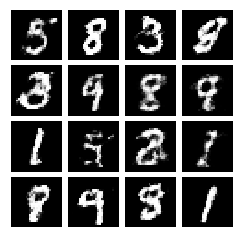

Iteration: 34000
Discriminator loss: 0.691
Generator loss: 2.33



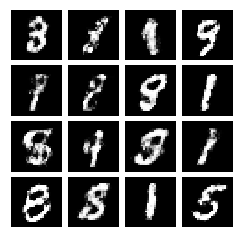

Iteration: 36000
Discriminator loss: 0.552
Generator loss: 2.62



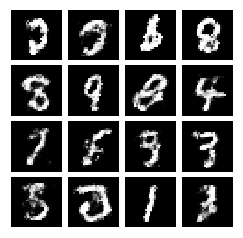

Iteration: 38000
Discriminator loss: 0.539
Generator loss: 2.62



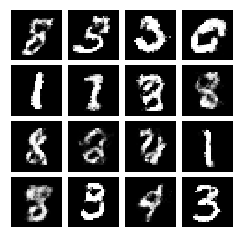

Iteration: 40000
Discriminator loss: 0.602
Generator loss: 2.65



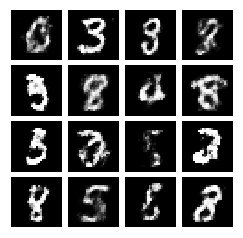

Iteration: 42000
Discriminator loss: 0.728
Generator loss: 2.32



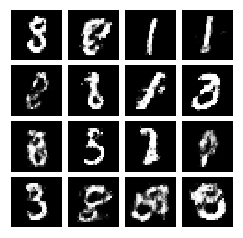

Iteration: 44000
Discriminator loss: 0.618
Generator loss: 2.48



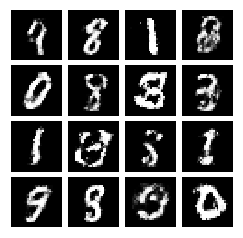

Iteration: 46000
Discriminator loss: 0.481
Generator loss: 2.52



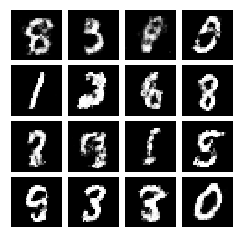

Iteration: 48000
Discriminator loss: 0.641
Generator loss: 2.42



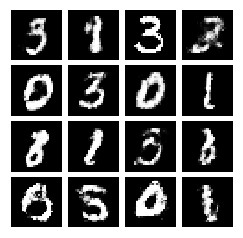

Iteration: 50000
Discriminator loss: 0.69
Generator loss: 2.18



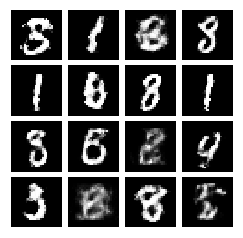

Iteration: 52000
Discriminator loss: 0.574
Generator loss: 2.56



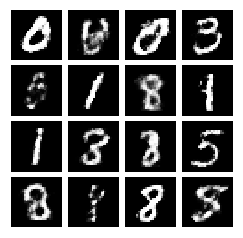

Iteration: 54000
Discriminator loss: 0.562
Generator loss: 2.36



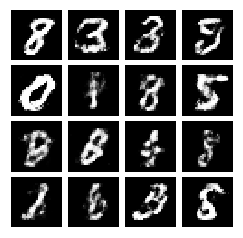

Iteration: 56000
Discriminator loss: 0.595
Generator loss: 2.27



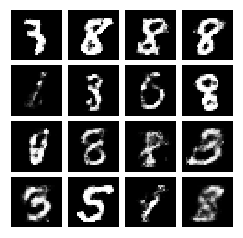

Iteration: 58000
Discriminator loss: 0.562
Generator loss: 2.29



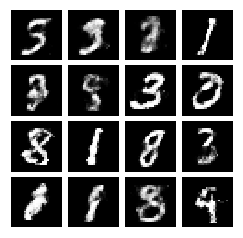

Iteration: 60000
Discriminator loss: 0.637
Generator loss: 2.34



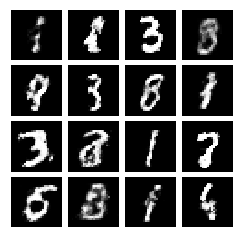

Iteration: 62000
Discriminator loss: 0.698
Generator loss: 2.16



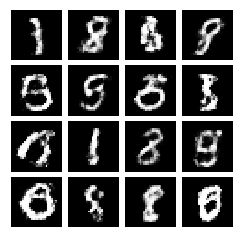

Iteration: 64000
Discriminator loss: 0.585
Generator loss: 2.27



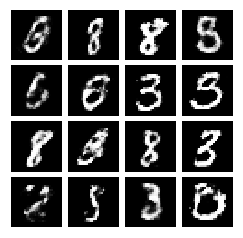

Iteration: 66000
Discriminator loss: 0.628
Generator loss: 2.15



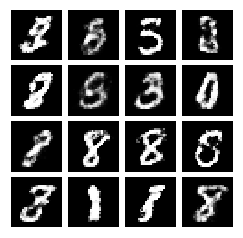

Iteration: 68000
Discriminator loss: 0.6
Generator loss: 2.3



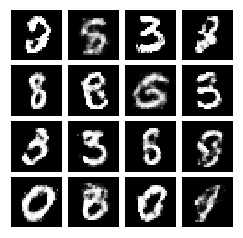

Iteration: 70000
Discriminator loss: 0.585
Generator loss: 2.33



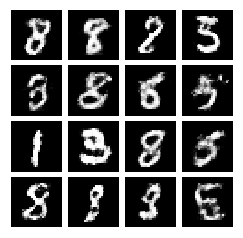

Iteration: 72000
Discriminator loss: 0.461
Generator loss: 2.58



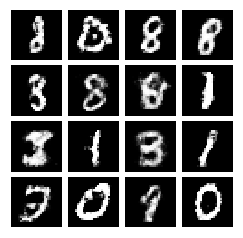

Iteration: 74000
Discriminator loss: 0.516
Generator loss: 2.13



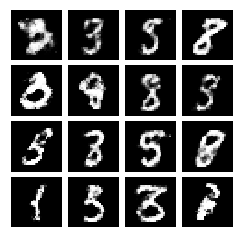

Iteration: 76000
Discriminator loss: 0.567
Generator loss: 2.38



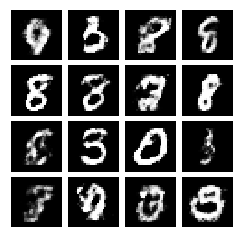

Iteration: 78000
Discriminator loss: 0.547
Generator loss: 2.31



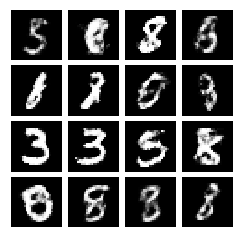

Iteration: 80000
Discriminator loss: 0.532
Generator loss: 2.17



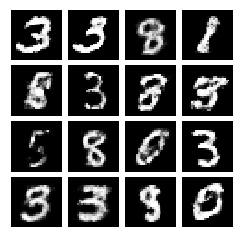

Iteration: 82000
Discriminator loss: 0.484
Generator loss: 2.2



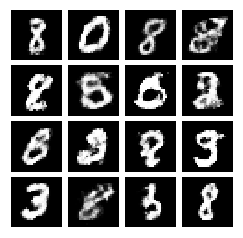

Iteration: 84000
Discriminator loss: 0.591
Generator loss: 2.17



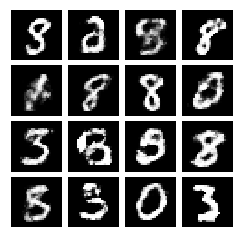

Iteration: 86000
Discriminator loss: 0.556
Generator loss: 2.5



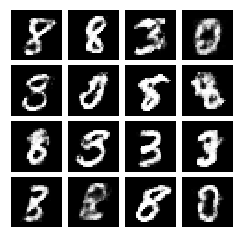

Iteration: 88000
Discriminator loss: 0.483
Generator loss: 2.55



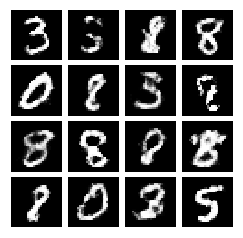

Iteration: 90000
Discriminator loss: 0.517
Generator loss: 2.36



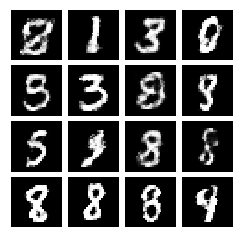

Iteration: 92000
Discriminator loss: 0.54
Generator loss: 2.49



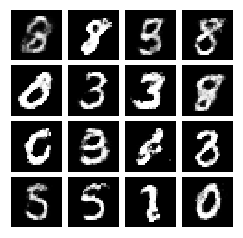

Iteration: 94000
Discriminator loss: 0.53
Generator loss: 2.43



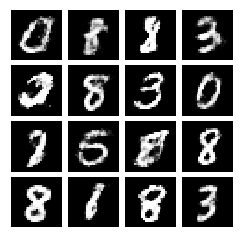

Iteration: 96000
Discriminator loss: 0.522
Generator loss: 2.16



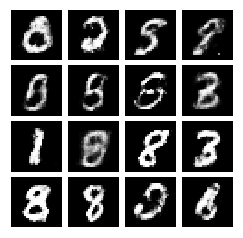

Iteration: 98000
Discriminator loss: 0.588
Generator loss: 2.28



In [131]:
i = 0

for j in range(100000):
    if j % 2000 == 0:
        samples = sess.run(sample_gen, feed_dict={Z: random_Z(16, dim_Z)})
        fig = plot(samples)
        plt.show()
        i += 1
        plt.close(fig)

    X_batch, _ = mnist.train.next_batch(batch_size)

    _, loss_curr_dis = sess.run([solver_dis, loss_dis], feed_dict={X: X_batch, Z: random_Z(batch_size, dim_Z)})
    _, loss_curr_gen = sess.run([solver_gen, loss_gen], feed_dict={Z: random_Z(batch_size, dim_Z)})

    if j % 2000 == 0:
        print 'Iteration: {}'.format(j)
        print 'Discriminator loss: {:.3}'. format(loss_curr_dis)
        print 'Generator loss: {:.3}'.format(loss_curr_gen)
        print